In [7]:

#使用するライブラリの読み込み
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import json
import os, sys
import scipy.io
from scipy import signal
import matplotlib as mpl
import matplotlib.pyplot as plt
import statistics
import math
import gc
from pypl2 import pl2_ad, pl2_spikes, pl2_events, pl2_info, pl2_comments
import sys
import os
import glia,tath,cosnail

In [8]:
#bandpass_filterの設定
def bandpass(x, samplerate, fp, fs, gpass, gstop):
    fn = samplerate / 2                           #ナイキスト周波数
    wp = fp / fn                                  #ナイキスト周波数で通過域端周波数を正規化
    ws = fs / fn                                  #ナイキスト周波数で阻止域端周波数を正規化
    N, Wn = signal.buttord(wp, ws, gpass, gstop)  #オーダーとバターワースの正規化周波数を計算
    b, a = signal.butter(N, Wn, "band")           #フィルタ伝達関数の分子と分母を計算
    y = signal.filtfilt(b, a, x)                  #信号に対してフィルタをかける
    return y                                      #フィルタ後の信号を返す


In [9]:
def plot_event(fig, axes, xlim):
    ax = fig.add_subplot(111, zorder=-1)
    ax.set_xlim(xlim[0], xlim[1])
    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
    ax.spines.left.set_visible(False)
    ax.spines.bottom.set_position(("outward", 10))
    ax.get_shared_x_axes().join(ax, axes[0])
    ax.tick_params(left=False, labelleft=False, right=False)
    ax.set_ylim([0, 1])
    ax.plot([0, 0], [0, 1], color="k", alpha=0.3)
    return

In [10]:
def format_axis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # remove ticks
    ax.tick_params(
        axis='y',          # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left=False,        # ticks along the left edge are off
        right=False,       # ticks along the right edge are off
        labelleft=False)   # labels along the left edge are off
    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    return

In [22]:
def plot_abrs(data,axes,samplerate):
    i=0
    keys=data.keys()
    values=data.values()
    for key,value in zip(keys,values):
        xlim=[0,20]
        #sampling_rate
        wave=value[:int(xlim[1]*samplerate/1000)]
        ylim=[-200,200]
        # Set limits and labels
        axes[i].set_facecolor("#ffffff00")
        axes[i].set_xlim(xlim[0],xlim[1])
        axes[i].set_ylim(ylim[0],ylim[1])
        axes[i].set_ylabel(key, rotation=0, ha="right", va="center")
        # Plot base line
        axes[i].plot(xlim, [0, 0], color="k", alpha=0.3, linestyle="--")
        # Plot waveform
        time=np.arange(xlim[0],xlim[1],1/(samplerate/1000))
        axes[i].plot(time, wave, color="k", clip_on=False,)
        # Format spines and ticks
        if i == len(keys)-1:
            axes[i].spines['top'].set_visible(False)
            axes[i].spines['left'].set_visible(False)
            axes[i].spines['bottom'].set_visible(False)
            axes[i].spines['right'].set_position(("outward", 10))
            axes[i].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
            axes[i].yaxis.tick_right()
            axes[i].set_yticks([ylim[0], 0, ylim[1]])
            axes[i].set_yticklabels([str(ylim[0]/1000), "0 μV", str(ylim[1]/1000)])
        else:
            format_axis(axes[i])
        i+=1
    return

In [23]:
def get_abr_data(mat_data,stim_table,samplerate=40000):
    active_chan=17
    reference_chan=18
    ground_chan=19
    active_wave=mat_data[f"WB{str(active_chan)}"]
    active_wave=list(active_wave[i][0] for i in range(len(active_wave)))
    reference_wave=mat_data[f"WB{str(reference_chan)}"]
    reference_wave=list(reference_wave[i][0] for i in range(len(reference_wave)))
    ground_wave=mat_data[f"WB{str(ground_chan)}"]
    ground_wave=list(ground_wave[i][0] for i in range(len(reference_wave)))
    #電圧値が非常に小さいため、平均で丸めると丸め誤差が大きそう、そのため厳密に各timestampに対して各波形を取り出し、A-G,R-Gを計算した後足していくこととする
    #timestampの取り出し、active,reference,groundの遅れ時間が同一計測方法であれば同一であるため(今後はtriggerchを用意するなどしたい)
    ts=mat_data[f"WB{str(active_chan)}_ts"][0][0]
    timestamp=mat_data["EVT01"]
    #samplerateを基準にWBでのtriggerのindexをtimestampに保存
    timestamp=list(int((timestamp[i][0]-ts)*samplerate) for i in range(len(timestamp))) #sampling_rateが1000であるため、1000をかけるとmsオーダーとなる
    #WBを描画するためmsのサンプリングレートを算出する必要がある
    samplerate_in_ms=samplerate//1000
    duration=15 #ms
    offset=5 #ms
    
    abr_dic={}
    index=0
    for timepoint in timestamp:
        #配列どうしの加減算を用意にするためにnp.arrayとして保存
        each_active=np.array(active_wave[timepoint-offset*samplerate_in_ms:timepoint+duration*samplerate_in_ms])
        each_ground=np.array(ground_wave[timepoint-offset*samplerate_in_ms:timepoint+duration*samplerate_in_ms])
        each_reference=np.array(reference_wave[timepoint-offset*samplerate_in_ms:timepoint+duration*samplerate_in_ms])
        #signal=active-ground base=reference-ground
        each_signal=each_active-each_ground
        each_base= each_reference-each_ground
        each_abr=each_signal-each_base
        line=stim_table.iloc[index]
        if line["state"]=="click":
            title=f'{line["db"]}'
        elif line["state"]=="us_burst":
            title=f'{line["amp"]*1000}mV_{line["duration"]*1000}ms_{line["pulse_duration"]*1000000}us_PRF{line["PRF"]}Hz_window{line["window"]}%'
        elif line["state"]=="us_cont":
            title=f'{line["amp"]*1000}mV_{line["duration"]*1000}ms_window{int(line["window"]*1000)}ms'
        if title in abr_dic:
            abr_dic[title]+=each_abr
        else:
            abr_dic[title]=each_abr
        index+=1
        
    #filter用変数設定
    fp=np.array([300,3000])
    fs=np.array([200,5000])
    gpass=10
    gstop=40
    #各電圧値を平均した後μVオーダーに変換
    for key in abr_dic:
        #平均する前にフィルタをかけて必要な帯域のみを取り出す
        abr_dic[key]=bandpass(abr_dic[key],samplerate,fp,fs,gpass,gstop)
        abr_dic[key]=abr_dic[key]*1000/350
    return abr_dic

In [24]:
#TDT用のABR描画プログラムの読み込み
#刺激波形・刺激ラベルの格納
filename="./TDT/512_epoc_0.csv"
#dataにデシベル:波形のdict形式で格納
data =cosnail.read_abrcsv(filename)
print(data.keys())
#該当ファイルにマッチする刺激ラベルの作成
stim_label=["c","p","us","usm",]
wave_status=[]
filename=tath.Path(filename).body
print(filename)

dict_keys(['80.0dB', '70.0dB', '60.0dB', '50.0dB', '40.0dB', '30.0dB', '20.0dB'])
512_epoc_0


In [25]:
#TDTのABR波形から波形を描画
fig, axes = plt.subplots(nrows=len(data.keys()), sharex=True, figsize=[9,6])
fig.patch.set_facecolor('white')
fig.suptitle("ABR recorded by TDT")
fig.supxlabel("Time from Stimulation (ms)")
fig.supylabel("Stim type")
xlim=[0,20]
plot_event(fig, axes, xlim)
plot_abrs(data,axes,25000)
if not (os.path.exists("./plot/")):
    os.mkdir("./plot")
fig.savefig("ABR_from_TDT.png") 
fig.clear()
plt.close(fig)
del axes  
del fig
gc.collect()
    

16014

In [70]:
#plxからmatlabへの変換ができないためpl2を使用する
filename="./Plexon/click_50dB_512_epoc_isi200ms_0.pl2"
# どんな情報が入っているかを示してくれるファイル
# spkinfo ソーティング用のクラスター情報が入っている
# evtinfo　計測されたevent情報が入っている
# adinfo 実波形データが格納されている
spkinfo, evtinfo, adinfo = pl2_info(filename)

In [71]:
evtinfo

(event_info(channel=1, name='EVT01', n=512),)

In [72]:
adinfo

(ad_info(channel=1, name='WB01', n=6612000),
 ad_info(channel=2, name='WB02', n=6612000),
 ad_info(channel=3, name='WB03', n=6612000),
 ad_info(channel=17, name='WB17', n=6612000),
 ad_info(channel=1, name='SPKC01', n=6611005),
 ad_info(channel=2, name='SPKC02', n=6611005),
 ad_info(channel=3, name='SPKC03', n=6611005),
 ad_info(channel=17, name='SPKC17', n=6611005),
 ad_info(channel=1, name='FP01', n=165275),
 ad_info(channel=2, name='FP02', n=165275),
 ad_info(channel=3, name='FP03', n=165275),
 ad_info(channel=17, name='FP17', n=165275))

In [73]:
#evtは名前で取り出す必要がある
evt=pl2_events(filename,evtinfo[0].name)
timestamps=np.array(list(evt.timestamps))

In [74]:
# ad()実波形の呼び出し情報はpl2_info参照
# SPKC1の読み込み
ad = pl2_ad(filename, "SPKC17")
#ad.ad tuple型で保存された波形を出力
#ad.timestamp 最初のtimestampが保存されているのでこれをずらす
wave=np.array(ad.ad)

In [75]:
#波形の取得時間を設定
samplerate=ad.adfrequency
samplerate_in_ms=samplerate//1000
duration=20 #ms
offset=0 #ms

In [76]:
ad.timestamps

(0.013025,)

In [77]:
#ad波形の遅れを補正
timestamps=timestamps-ad.timestamps[0]

In [78]:
fixed_timestamps=np.array(list(map(int,timestamps*samplerate)))

In [50]:
ad = pl2_ad(filename, "WB17")
wb_wave=np.array(ad.ad)

0.0001129150390625


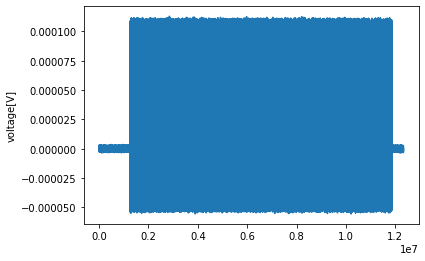

In [54]:
#波形の描画
#time=np.arange(-offset,duration,1/samplerate_in_ms)
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(wave)
print(np.max(np.abs(wave)))
# ax.set_xlabel("time[ms]")
ax.set_ylabel("voltage[V]")
#ax.set_ylim(-0.0125,0.0125)
plt.savefig("50dB_click_from_ch17.png")
#plt.show()
#clickの立ち上がり->10サンプル=時間長:10/40000=2.5*10^(-4)s=0.25ms=250us程度の誤差
#2サンプルだとさらに50μSくらいの誤差
#サンプリングレート25000だと1サンプルの時間幅は40μSなので1サンプルずれているかどうかくらいには収まりそう

In [79]:
#timestampの情報を元に波形の加算平均を行う。
total_wave=np.zeros(int((duration-offset)*samplerate_in_ms))
i=0
for timepoint in timestamps:
    each_wave=np.array(wave[int(timepoint-offset*samplerate_in_ms):int(timepoint+duration*samplerate_in_ms)])
    if len(each_wave)==len(total_wave):
        total_wave+=each_wave
        i+=1
total_wave/=i
print(i)
total_wave*=1000000

512


0.2795457839965813


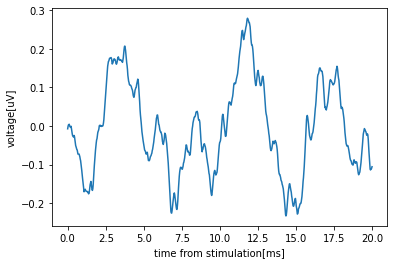

In [80]:
time=np.arange(-offset,duration,1/samplerate_in_ms)
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(time,total_wave)
ax.set_xlabel("time from stimulation[ms]")
ax.set_ylabel("voltage[uV]")
#ax.set_ylim(-0.0125,0.0125)
plt.savefig("50dB_click_pns_512_ave.png")
#plt.show()
print(np.max(np.abs(total_wave)))

1000回平均した時のノイズレベルは120μV
512回平均した時のノイズレベルは270uV
だった→Plexonで計測するときには1000回ほど加算平均する必要がありそう？

In [55]:
#timestampsの結果とSPKC17の立ち上がり電圧タイミングを比較する
#閾値は0.1μsとする
timestamps_from_SPKC=[]
i=0
while i<len(wave):
    if wave[i]>=1.0*10**-5:
        timestamps_from_SPKC.append(i/samplerate)
        #次のクリック音が入りそうな区間まで飛ばす
        i+=int(0.06*samplerate)
    else:
        i+=1

In [56]:
timestamps_from_SPKC=np.array(timestamps_from_SPKC)

In [57]:
timestamps

array([ 31.718125,  31.97835 ,  32.245   ,  32.5107  ,  32.7605  ,
        33.021475,  33.291925,  33.563425,  33.831325,  34.084725,
        34.3509  ,  34.607775,  34.860925,  35.127375,  35.3838  ,
        35.6509  ,  35.908275,  36.16115 ,  36.41275 ,  36.660075,
        36.89775 ,  37.15285 ,  37.400325,  37.660225,  37.944475,
        38.2201  ,  38.461   ,  38.719225,  38.960525,  39.2185  ,
        39.4782  ,  39.7411  ,  40.0107  ,  40.276125,  40.525325,
        40.79135 ,  41.07285 ,  41.340025,  41.622275,  41.90105 ,
        42.14305 ,  42.397975,  42.671475,  42.9417  ,  43.19375 ,
        43.467175,  43.7283  ,  44.038825,  44.310175,  44.5762  ,
        44.8439  ,  45.119075,  45.4075  ,  45.6743  ,  45.930225,
        46.207625,  46.482375,  46.730175,  47.0103  ,  47.271825,
        47.5451  ,  47.835975,  48.112375,  48.38125 ,  48.636425,
        48.886625,  49.15215 ,  49.422475,  49.710375,  49.9713  ,
        50.228475,  50.487675,  50.755575,  51.0203  ,  51.268

In [58]:
timestamps_from_SPKC

array([ 31.71815 ,  31.978375,  32.245025,  32.510725,  32.760525,
        33.0215  ,  33.29195 ,  33.56345 ,  33.83135 ,  34.084775,
        34.350925,  34.607825,  34.86095 ,  35.1274  ,  35.383825,
        35.650925,  35.9083  ,  36.161175,  36.412775,  36.6601  ,
        36.897775,  37.152875,  37.400375,  37.66025 ,  37.9445  ,
        38.220125,  38.461025,  38.71925 ,  38.96055 ,  39.218525,
        39.478225,  39.741125,  40.010725,  40.276175,  40.52535 ,
        40.791375,  41.072875,  41.34005 ,  41.6223  ,  41.901075,
        42.143075,  42.398   ,  42.6715  ,  42.941725,  43.193775,
        43.4672  ,  43.728325,  44.03885 ,  44.3102  ,  44.576225,
        44.843925,  45.1191  ,  45.407525,  45.674325,  45.930275,
        46.20765 ,  46.4824  ,  46.730225,  47.010325,  47.27185 ,
        47.545125,  47.836   ,  48.1124  ,  48.381275,  48.63645 ,
        48.88665 ,  49.152175,  49.4225  ,  49.7104  ,  49.971325,
        50.2285  ,  50.4877  ,  50.7556  ,  51.020325,  51.268

In [59]:
#長さの確認→あっている
print(len(timestamps),len(timestamps_from_SPKC))
type(timestamps_from_SPKC)

1000 1000


numpy.ndarray

0.05000000004429239


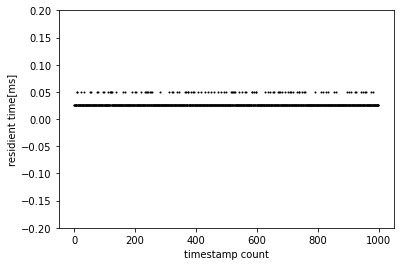

In [60]:
#timestampと入力した信号の残差プロット
x=range(len(timestamps_from_SPKC))
y=(timestamps_from_SPKC-timestamps)*1000
print(np.max(y))
fig=plt.figure()
ax=fig.add_subplot(111)
#help(ax.scatter)
ax.scatter(x,y,color="k",s=1)
ax.set_ylim(-0.2,0.2)
ax.set_title("")
ax.set_ylabel("residient time[ms]")
ax.set_xlabel("timestamp count")
plt.savefig("residient_plot_of_timestamps_50dB_click_-0.2-0.2.png")